In [1]:
# Data Analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f, gamma

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 300

## 1. Get positions of ancestral deletion and coverage

In [2]:
data = pd.read_csv("/media/urbe/MyADrive1/Antoine/13-12-2021_Analysis_GR_MA/deletion_C1A_adjusted.csv")
data

,chr,pos,ancestral,t0,t0_smooth,t1,t1_smooth
0,Chrom_1,6749498,1.0,1.017327,1.015674,1.001207,1.002820
1,Chrom_1,6749663,1.0,1.017893,1.015824,1.001413,1.002868
2,Chrom_1,6749721,1.0,1.018388,1.015970,1.001660,1.002914
3,Chrom_1,6749737,1.0,1.019165,1.016110,1.001877,1.002959
4,Chrom_1,6749811,1.0,1.018953,1.016244,1.002145,1.003003
...,...,...,...,...,...,...,...
11613,Chrom_1,7706604,1.0,0.963013,0.946237,1.017739,0.997867
11614,Chrom_1,7706619,1.0,0.961174,0.946103,1.017420,0.997516
11615,Chrom_1,7706681,1.0,0.960042,0.945969,1.017059,0.997165
11616,Chrom_1,7706689,1.0,0.958911,0.945836,1.016687,0.996811


In [3]:
pmin, pmax = 7047000, 7383000
preprocess = data[["pos", "t0", "t1"]]
scaler = MinMaxScaler()
X = preprocess["pos"].values
X = X.reshape(-1, 1)
scaler.fit(X)
[pmin], [pmax] = scaler.transform([[pmin], [pmax]])
preprocess = preprocess.assign(normPos=scaler.transform(X))
print(pmin, pmax)

0.3108063778084693 0.6618323976121872


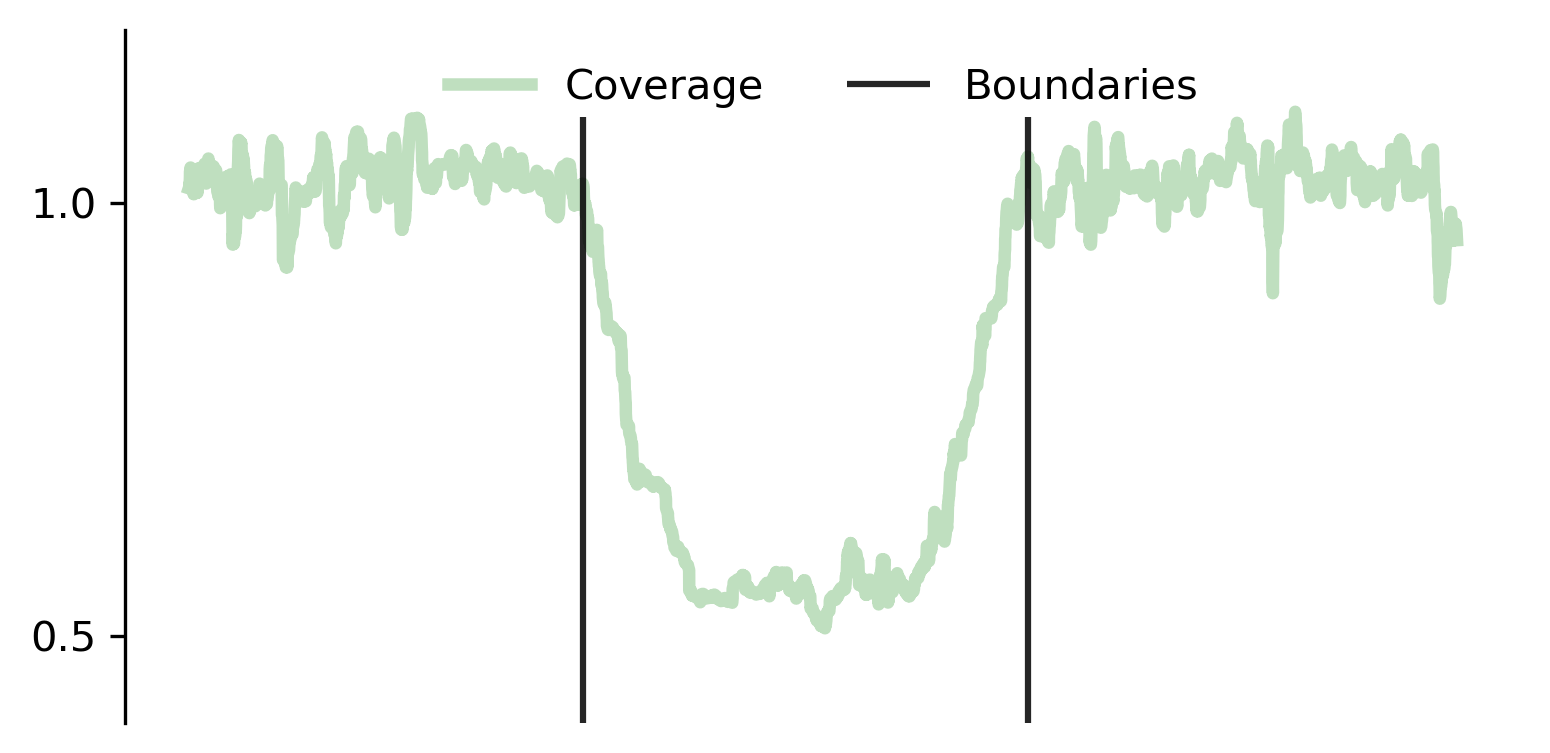

In [26]:
fig,ax = plt.subplots(figsize=(6,3))


ax.plot(preprocess["normPos"], preprocess["t0"], color="g", lw=3.0, alpha=0.25, label="Coverage", zorder=3)
#ax.plot(preprocess["normPos"], preprocess["t1"], color="r", lw=3.0, alpha=0.25)

ax.spines[["right","bottom", "right", "top"]].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0.5,1.0])
ax.tick_params(axis="x", length=0)

ax.vlines([pmin, pmax], ymin=0.4, ymax=1.1, color="k", label="Boundaries", alpha=0.85, zorder=5)

ax.set_ylim(0.4,1.2)
#ax.axhline(0.5, color="k", zorder=0, lw=0.5, linestyle="dashed")
#ax.axhline(1.0, color="k", zorder=0, lw=0.5, linestyle="dashed")

ax.legend(loc="upper center", frameon=False, ncol=2)

plt.show()

## 2. Get undeleted sequence

In [5]:
def get_original_sequence_from_fasta(fasta, chrom, start, end) :
    
    seqs = {}
    f = open(fasta, "r")
    for line in f :
        if line.startswith(">") :
            name = line.strip().split()[0][1:]
            seqs[name] = ""
        else :
            seqs[name] += line.strip()
    f.close()
    
    return seqs[chrom][start:end+1]

In [6]:
reference = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/reference.fa"
ancestral_sequence = get_original_sequence_from_fasta(reference, "Chrom_1", 6749498, 7706692)

In [7]:
actual_sequence_end = 7706692
actual_sequence_start = 6749498
cut_sequence_start = 7047000 - actual_sequence_start
cut_sequence_end = 7383000 - actual_sequence_start

deleted_sequence = ancestral_sequence[0:cut_sequence_start+1] + ancestral_sequence[cut_sequence_end:]
print("Ancestral:", len(ancestral_sequence), "Deleted:", len(deleted_sequence), "Difference:", len(ancestral_sequence) - len(deleted_sequence))

Ancestral: 957195 Deleted: 621196 Difference: 335999


In [8]:
def create_population_of_deletions(ancestral_sequence, cut_sequence_start, cut_sequence_end, offset) :
    
    length = len(ancestral_sequence)
    
    start = cut_sequence_start
    end = cut_sequence_end
    shape, scale = 2e2, 4e3

    x1 = np.arange(0, length)
    y1 = gamma.pdf(x1, a=shape, scale=scale, loc=offset+start-scale*shape)
    
    y2start = length - end
    x2 = np.arange(0, length)
    y2 = gamma.pdf(x2, a=shape, scale=scale, loc=offset+y2start-scale*shape)
    
    sumy = y1 + y2[::-1]
    #sumy /= 2
    #print("Sum(y1+y2): ", sum(sumy))
    
    # DRAW STARTS
    start_positions = np.copy(x1)
    normalized_probabilities = y1 / np.sum(y1)
    random_start_positions = np.random.choice(start_positions, size=50, p=normalized_probabilities)
    
    # DRAW STOPS
    stop_positions = np.copy(x2)
    normalized_probabilities = y2[::-1] / np.sum(y2[::-1])
    random_stop_positions = np.random.choice(stop_positions, size=50, p=normalized_probabilities)
    
    fig, ax = plt.subplots(figsize=(6,3))
    
    ax.plot(x1, sumy, color="k")
    
    ax.vlines([cut_sequence_start, cut_sequence_end], ymin=min(sumy), ymax=max(sumy))
    ax.set_xlabel('Position')
    ax.set_ylabel('Probability')
    plt.show()
    
    return random_start_positions, random_stop_positions

def plot_deleted_density(ancestral_sequence, start_positions, stop_positions) :
    density = np.zeros(len(ancestral_sequence))

    i = 0
    for ns, ne in zip(start_positions, stop_positions) :
        # when ns > ne -> I consider it repaired (rates are wrong it is just a matter of simulating deletions)
        if ns < ne :
            density[ns:ne+1] += 1
            #ax.plot([ns, ne], [i,i], lw=0.5, color="k", alpha=1.0)
            i += 1

    density /= i # normalize by deletion number

    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(density, color="k")
    plt.show()

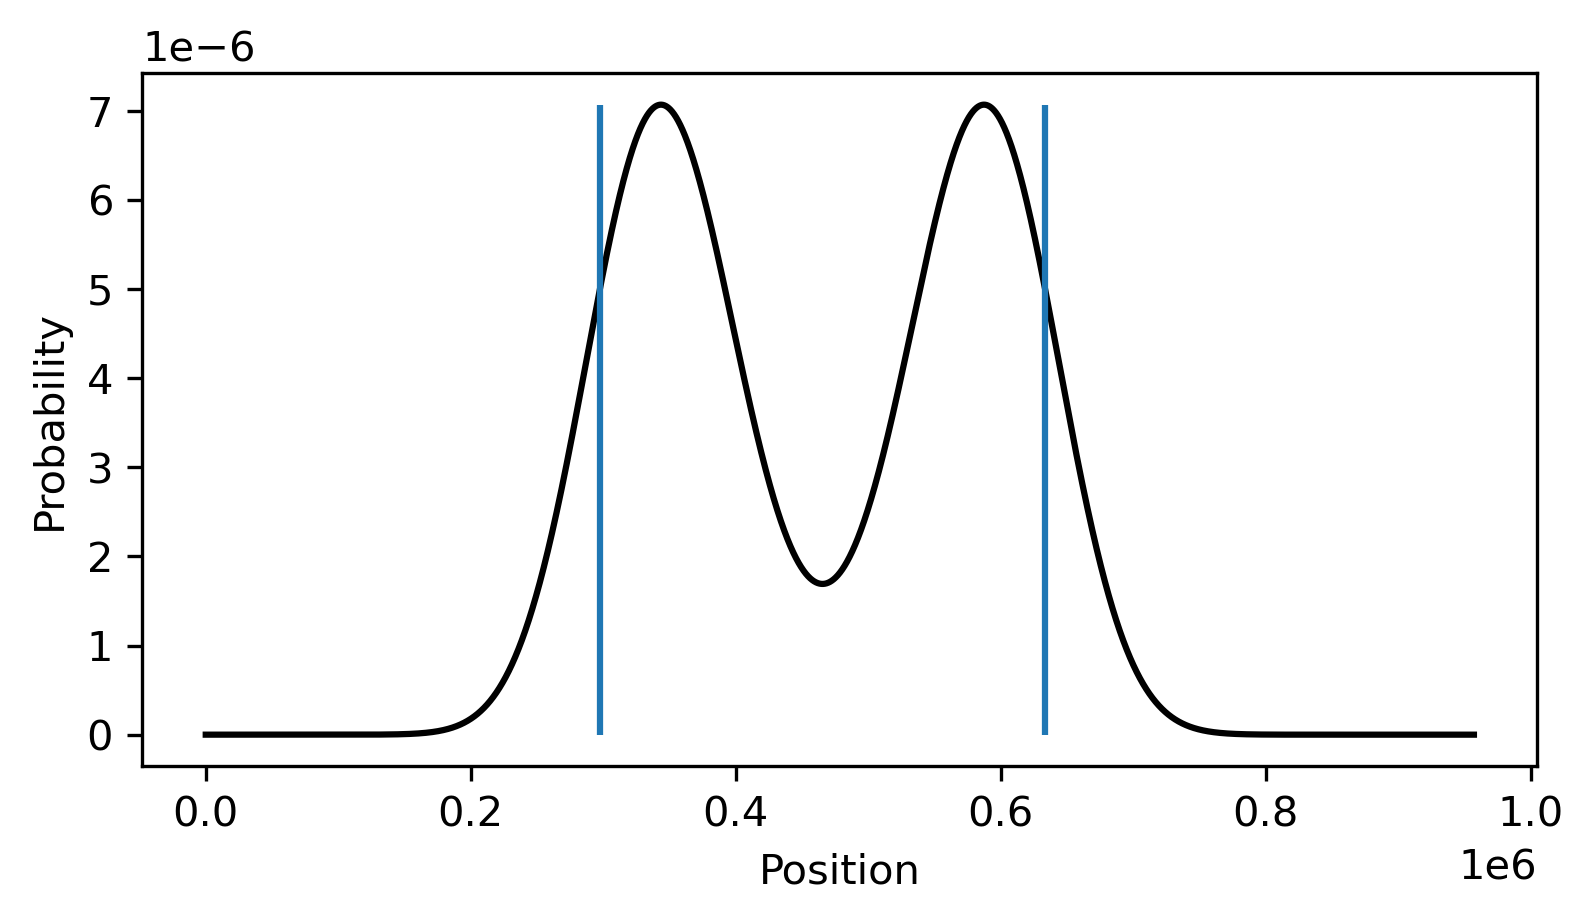

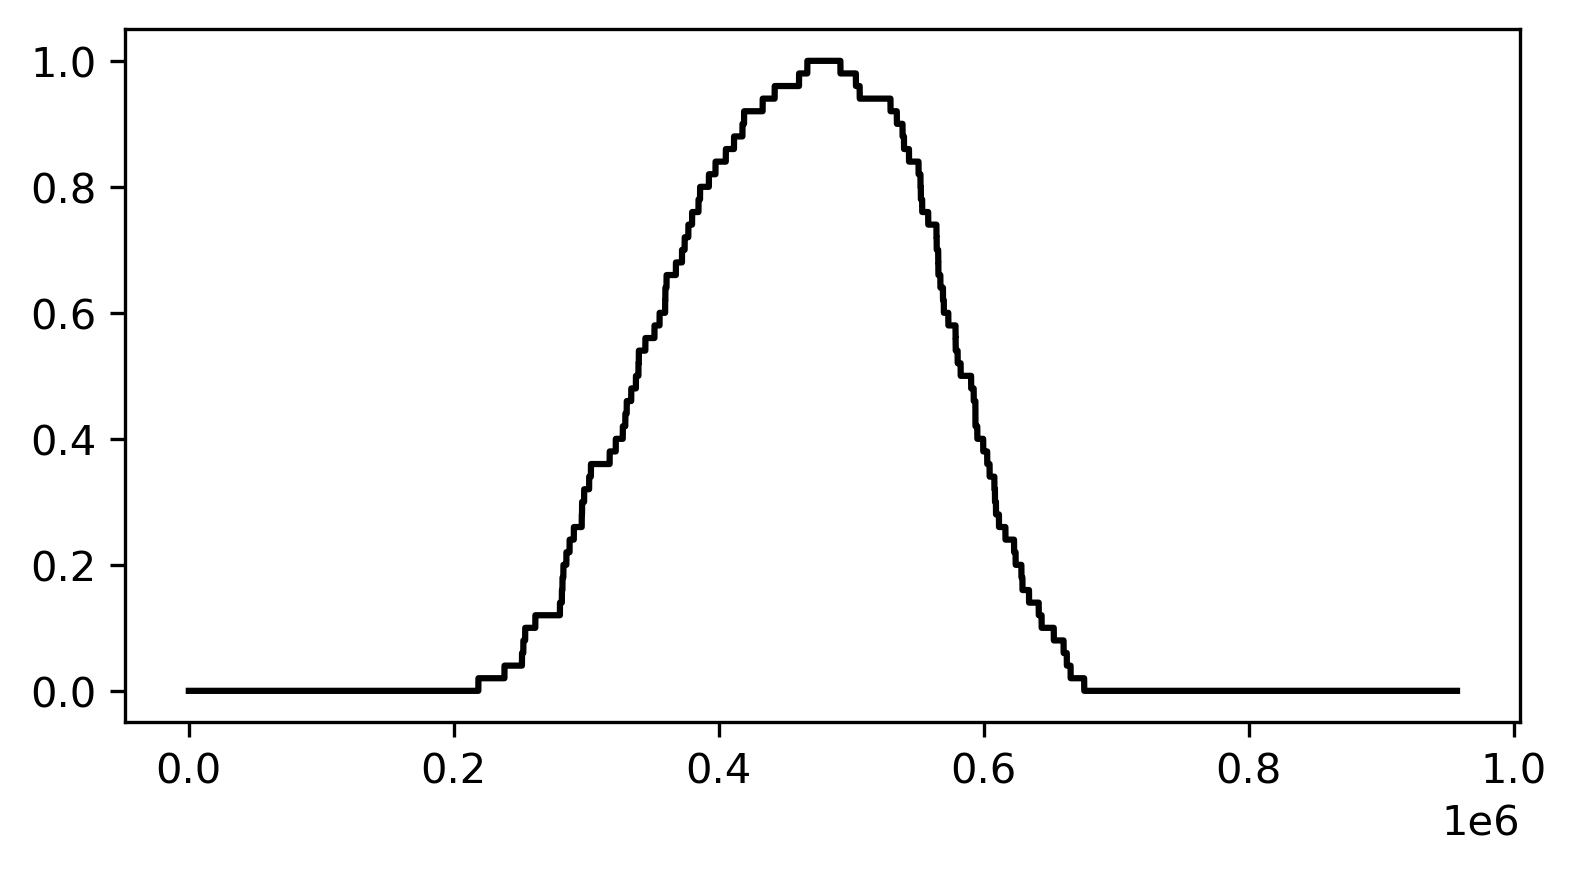

In [9]:
start_positions, stop_positions = create_population_of_deletions(ancestral_sequence, cut_sequence_start, cut_sequence_end, offset=5e4)
plot_deleted_density(ancestral_sequence, start_positions, stop_positions)

In [13]:
def create_deletions(ancestral_sequence, start_positions, stop_positions) :
    
    merged_deletions = []
    separated_deletions = []
    
    for ns, ne in zip(start_positions, stop_positions) :
        # when ns > ne -> I consider it repaired (rates are wrong it is just a matter of simulating deletions)
        if ns < ne :
            
            merged_deletions.append(ancestral_sequence[:ns+1]+ancestral_sequence[ne:])
            separated_deletions.append(ancestral_sequence[:ns+1])
            separated_deletions.append(ancestral_sequence[ne:])
    
    return merged_deletions, separated_deletions

In [14]:
merged_deletions, separated_deletions = create_deletions(ancestral_sequence, start_positions, stop_positions)

In [15]:
def write_fasta(output, ancestral_sequence, merged_deletions, separated_deletions) :
    
    om = open(output + ".merged.fa", "w")
    for i, deleted_seq in enumerate(merged_deletions) :
        om.write(">merged_deletion_{}\n".format(i))
        om.write("{}\n".format(deleted_seq))
        om.write(">ancestral_{}\n".format(i))
        om.write("{}\n".format(ancestral_sequence))
        
    om.close()
    
    os = open(output + ".separated.fa", "w")
    for i, deleted_seq in enumerate(separated_deletions) :
        os.write(">separated_deletion_{}\n".format(i))
        os.write("{}\n".format(deleted_seq))
        os.write(">ancestral_{}\n".format(i))
        os.write("{}\n".format(ancestral_sequence))
    os.close()

In [16]:
write_fasta("deletion_simulation_1", ancestral_sequence, merged_deletions, separated_deletions)

In [17]:
%%bash

N50 deletion_simulation_1.separated.fa
echo ""
N50 deletion_simulation_1.merged.fa

#contigs: 200
Total size: 131157724
N50: 957195		L50: 69
N75: 442149		L75: 106
N90: 348779		L90: 157
N99: 261504		L99: 195
Average: 655788

#contigs: 100
Total size: 83297974
N50: 957195		L50: 44
N75: 733380		L75: 69
N90: 674534		L90: 87
N99: 576535		L99: 99
Average: 832979


## 3. Nanopore read simulation

Using `nanosim`:

```bash
### Analysis
reads=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/READS/PAG10697.PAF32118a.validated.pass.fastq.gz
genome=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/reference.fa
bam=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam
threads=24
output=training_ont_sim

## Done in folder for space issues: /media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion
read_analysis.py genome -i $reads -rg $genome -t $threads -a minimap2 -ga $bam

### NOTE: Ran a first time with default parameters then checked the length distributions and adapted parameters to the real dataset
# min: 113
# max: 205207
# mean: 25426.280095133552
# median: 22611.0
# std: 17033.29534186606
# log(std): 9.74

# in /media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT
mkdir SIMULATED_READS

### Simulation on merged deletion
ref=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/deletion_simulation_1.merged.fa
model=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/training
output=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/SIMULATED_READS/reads_simulated_merged
threads=24
simulator.py genome -rg $ref -c $model -o $output -t $threads -min 113 -max 205207 -med 22611 -sd 1.05

# NOTE: I tried with sd == 9.74 and more but the simulation ran for hours without outputting any reads at all -> *stuck* so I used 1.05 instead.

### Simulation on split deletion
ref=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/deletion_simulation_1.separated.fa
model=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/training
output=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/SIMULATED_READS/reads_simulated_separated
threads=24
simulator.py genome -rg $ref -c $model -o $output -t $threads -min 113 -max 205207 -med 22611 -sd 1.05
```